# Differential Analysis of Ribosome Pausing

This section will cover how to determine if an experimental condition induces rate limiting pauses during translation elongation. First, the count arrays from the last section will be loaded into a Jupyter notebook and filtered so that only transcripts with sufficient length and read coverage are analyzed. Then, LOESS smoothing will be performed on the filtered count arrays and the cumulative distributions of the smoothed count arrays will be calculated. These cumulative distributions will be used to calculate the KS statistic for each gene. All of the genes will then be sorted into 3 separate bins based on whether they have low, medium, or high KS statistics. The fold enrichment of genes affected by the experimental condition within each bin is then calculated. Finally, Fisher’s exact test will be used to determine if any of the observed enrichment of the target genes is significant. 

### Step 26
Load in all of the necessary Python packages. 

In [1]:
# Load up the necessary packages 
import numpy as np
import pandas as pd
import dif_utils as dif
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
from multiprocess import Pool

In [2]:
# Define the path to our data files and the path we want to save our outputs in. 
data_path = "/home/keeganfl/Desktop/Work_Fall_2021/Protocol_test/genome/mouse/"
target_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/'
counts_path = "/home/keeganfl/Desktop/Work_Fall_2021/Protocol_test/position_counts_seleno/"
image_path = '/home/keeganfl/Desktop/Work_Fall_2021/Presentation_figures/'
mutation = 'Trspfl'
samp_num = '2'

### Step 27
Load in the count arrays for the experimental and control datasets. 

In [3]:
# Load in the count positions data.
data_mutant, names_mutant = dif.load_count_positions(counts_path + mutation+"_"+samp_num+"_counts.csv")
data_control, names_control = dif.load_count_positions(counts_path + "control_"+ samp_num +"_counts.csv")

### Step 28
Smooth out the count arrays using LOESS smoothing and calculate the cumulative read distributions. The get_smoothed_vector function from the diff_utils.py file is set up to perform Loess smoothing with a window size equal to 5% of the transcript length and calculates the cumulative read distribution. This step can take some time so it is recommended to use the multiprocess’ Pool() function to complete this using multiple cores. 

In [5]:
max_pool = 8

# get smoothed vector arrays for all of the control data.
with Pool(max_pool) as p:
    pool_control, pool_mutant = list(
            p.imap(dif.get_smoothed_vector,
                   data_control)
        ), list(
            p.imap(dif.get_smoothed_vector,
                    data_mutant)
        )

### Step 29
For each gene in the experimental and control datasets, calculate the KS-statistic as the maximum distance between their smoothed cumulative distributions and then save this KS-statistic as a list.  

In [6]:
ks_list = []
len_list = []
for tr_m, tr_c, index in zip(data_mutant, data_control, list(range(len(data_mutant)))):
    position = np.array(list(range(len(tr_m))))
    smoothed_vec_m, cumul_m = pool_mutant[index]
    smoothed_vec_c, cumul_c = pool_control[index]

    ks = max(abs(cumul_m - cumul_c))
    ks_list.append(ks)
    len_list.append(len(tr_m))

### Step 30
Combine the lists for the gene IDs, gene lengths, and KS statistics into a pandas dataframe using the Pandas’ DataFrame function and rename the columns of the dataframe to something more suitable. 

In [7]:
# reorganizing the lists into a dataframe. 
ks_table = pd.DataFrame(list(zip(names_mutant, ks_list, len_list)))
ks_table.columns = ["gene_ID", "ks_stat", "gene_length"]

### Step 31
Load up a table containing a list of names for the genes affected by our experimental condition and load up the KS table created during the previous section using Pandas’ read_csv function. The genes affected by the experimental condition will be referred to as target genes or targets.

In [8]:
target_table = pd.read_csv(target_path + 'Selenoprotein_table.csv', names = ["gene_ID"])

### Step 32
Merge the table of KS statistics and the table of target gene names into a new table using Pandas’ merge function. This new table will have an indicator column that shows if one of the target genes matched to one of the genes in the table of KS statistics. Then, sort the new table from lowest K-S statistic to highest K-S statistic to help with the plotting in later steps. 

In [9]:
# merge the KS and target tables.
temp_df = pd.merge(ks_table, target_table, how='left', on='gene_ID', indicator = True)

# sort the data by the KS satistic of each gene
temp_df = temp_df.sort_values(by = "ks_stat")
temp_df = temp_df.reset_index(drop=True)

### Step 33
Clean up your new table by removing any duplicates that may have been caused by multiple transcripts having the same gene name. 

In [10]:
temp_df.drop_duplicates(subset ="gene_ID",keep = "first", inplace = True) 

### Step 34
Use the indicator column created in step 32 to create 2 subsets of our table of KS statistics; one that only includes genes which matched with our target genes and one that only includes genes which did not match with our target genes.

In [11]:
targets = temp_df[temp_df._merge == "both"]

non_targets = temp_df[temp_df._merge == "left_only"]

### Step 35
Use matplotlib’s scatter function to create a scatterplot which shows the KS statistic for all of the target and non-target genes. 

(0.0, 0.7)

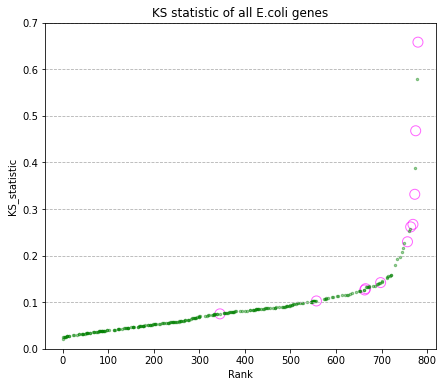

In [20]:
figure(figsize = (7,6))
plt.scatter(list(targets.index), targets["ks_stat"], s=100, alpha = 0.6, facecolors = 'none', edgecolors = 'magenta')
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all EFP targets")
plt.ylim(0,0.7)

plt.scatter(list(non_targets.index), non_targets["ks_stat"], s=6, alpha = 0.4, color = "g")
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all E.coli genes")
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.ylim(0,0.7)

### Step 36
Divide the data into low, medium, and high KS fractions and determine the fold enrichment of the target genes in each fraction using the determine enrichment function from dif_utils.py. The KS fractions in this example are set as all genes with a KS stat less than 0.15, All genes with a KS stat between 0.15 and 0.3, and all genes with a KS stat above 0.3. 

In [21]:
# Calculate the proportion of genes which are Fmr1 targets in a high, medium, and low KS fraction
upper_ks = 0.3
N_cats = 2
enrich_dmel, sections_dmel = dif.determine_enrichment(targets, non_targets, upper_ks, N_cats)

### Step 37
Use matplotlib’s pyplot.bar function to create a series of barplots that show the fold enrichment of genes that are targets in each fraction. 

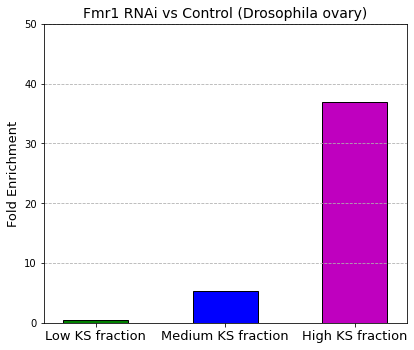

In [22]:
# Create a bar plot that shows the proportion of genes which are Fmr1 targets in each KS fraction.
figure(figsize = (6.5,5.5))
plt.bar([1,2,3],enrich_dmel, width = 0.5,
        tick_label = ["Low KS fraction","Medium KS fraction","High KS fraction"], 
       color = ["g", 'b', 'm'], edgecolor = 'black')
plt.xticks(fontsize = 13)
plt.xlim(0.6,3.4)
plt.ylim(0, 50)
plt.ylabel("Fold Enrichment", fontsize = 13)
plt.title("Fmr1 RNAi vs Control (Drosophila ovary)", fontsize = 14)
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")

### Step 38
Perform Fisher’s exact test to determine if the difference between the observed and expected target proportions are significant. The Fisher_exact_p_values function from dif_utils.py can be used to automatically calculate these P-values for each of the KS fractions. 

In [23]:
# determine if the difference betwqeen the expected proportion of targets 
# and the observed proportion of targets is significant
dif.Fisher_exact_p_values(targets, non_targets, sections_dmel)

[4.0309533336409694e-05, 0.02231943324108509, 0.0004271941938465886]

## (Optional) Choose a gene of interest and observe the smooth and unsmoothed array.

In [24]:
# Choosing a gene of interest to calculate the elongation rates of. 
# Get the transcript and vector for the gene of interest.
my_gene = 'Txnrd1'
my_vec_mutant = None
my_vec_control = None
for tr_m, tr_c, name in zip(data_mutant, data_control, names_mutant):
    if name == my_gene:
        my_vec_mutant = tr_m
        my_vec_control = tr_c
if my_vec_mutant.any() == None:
    print("No gene found")

In [25]:
smoothed_vec_m, cumul_m = dif.get_smoothed_vector(my_vec_mutant+0.00000000001)
smoothed_vec_c, cumul_c = dif.get_smoothed_vector(my_vec_control+0.00000000001)

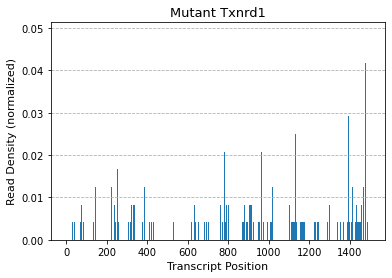

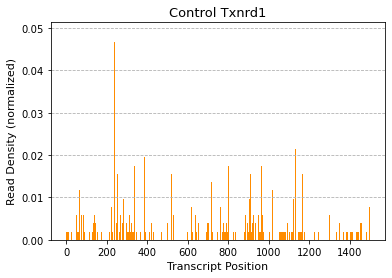

In [26]:
maxi = max([max(my_vec_mutant/sum(my_vec_mutant)), max(my_vec_control/sum(my_vec_control))])

plt.bar(list(range(len(my_vec_mutant))),my_vec_mutant/sum(my_vec_mutant), width = 4)
plt.ylim([0,maxi*1.1])
plt.ylabel("Read Density (normalized)", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Mutant " + my_gene, fontsize = 13)
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.savefig(image_path + my_gene + '_mutant_array.pdf')
plt.show()
plt.bar(list(range(len(my_vec_mutant))), my_vec_control/sum(my_vec_control), color = "darkorange", width = 4)
plt.ylim([0,maxi*1.1])
plt.ylabel("Read Density (normalized)", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Control " + my_gene, fontsize = 13)
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.savefig(image_path + my_gene + '_control_array.pdf')

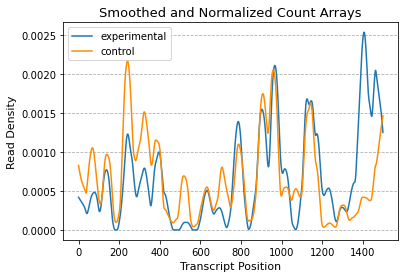

In [27]:
plt.plot(smoothed_vec_m, label = "experimental")
plt.plot(smoothed_vec_c, label = "control", color = "darkorange")
plt.ylabel("Read Density", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Smoothed and Normalized Count Arrays", fontsize = 13)
plt.legend()
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.savefig(image_path + my_gene +'_smoothed.pdf')

In [28]:
ks = max(abs(cumul_m - cumul_c))

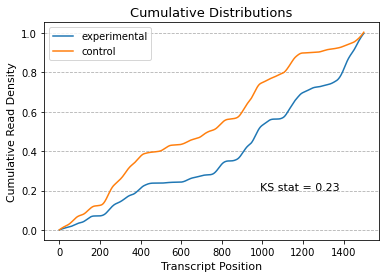

In [29]:
plt.plot(cumul_m, label = "experimental")
plt.plot(cumul_c, label = "control")
plt.text(len(cumul_c)*0.66, 0.2, "KS stat = " + str(round(ks,3)), fontsize = 11)
plt.ylabel("Cumulative Read Density", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Cumulative Distributions", fontsize = 13)
plt.legend()
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.savefig(image_path + my_gene + '_cumulative.pdf')